# Landscape generation

In this notebook we show how to use `topsearch` to map the landscape of the two-dimensional Schwefel function. The function we use here is in two dimensions to allow direct visualisation of the output, which makes the process easier to understand. We will link any relevant research papers at each step, but provide a short description that should be sufficient to follow the process.
We will perform several tasks in turn for the Schwefel function:
1. Global optimisation
2. Finding transition states
3. Restart from partial landscape
4. Restart with multiprocessing

The main aim of `topsearch` is to map the topography of surfaces using the energy landscape framework (https://doi.org/10.1146/annurev-physchem-050317-021219). Key to this framework is the location of stationary points (points with zero gradient): minima and transition states. Local minima are points from which any displacement increases the energy, and transition states are points that are maximal in one direction and minimal in all the remaining orthogonal directions. Transition states can be diagnosed by a single negative eigenvalue of the second derivative matrix. The set of stationary points are stored in a network in which minima are nodes and transition states are edges between nodes, this network is known as a kinetic transition network (https://doi.org/10.1016/j.sbi.2008.01.008). In physical systems such a network can be used to compute all physical properties, but such a representation of the topology is useful for abstract surfaces too (https://doi.org/10.1039/D3DD00204G). In this example we compute the kinetic transition network for the Schwefel function; an example network is shown below to illustrate the aims.

![alt text](StationaryPointsExample.png "Title")

Local minima and transition states are shown by green and red circles, respectively. The downhill direction at each transition state is shown with pink arrows, and the two minima connected to each transition state are joined with solid black lines.

## Initialise classes

Before we run any calculations we require several classes to be instantiated. We list each of them in turn here, and describe their functionality. First, we specify the coordinates class, which stores and operates on a position within the space specified by its bounds and dimensionality.

In [106]:
from topsearch.data.coordinates import StandardCoordinates
coords = StandardCoordinates(ndim=2, # specify a position in two dimensions
                             bounds=[(-500.0, 500.0),
                                     (-500.0, 500.0)]) # specify the extent in each dimension

We require the potential class that specifies the function that we want to explore, in this case the Schwefel function. The class provides the functionality to compute the function value and its first and second derivatives when given a set of coordinates.

In [107]:
from topsearch.potentials.test_functions import Schwefel
schwefel = Schwefel()

Next we initialise the comparison class, which is responsible for determining the distance between coordinates and whether they are the same point. We may generate repeated minima and transition states and the functions of this class will allow us to filter out repeats so we only include unique stationary points. We are required to specify a `distance_criterion` and `energy_criterion` within which two minima and transition states are considered the same. The proportional_distance scales the distance_criterion to reflect the total range in each dimension. In the example below any points within 0.01*1000=10.0 and a function difference of 0.01 are considered the same.

In [108]:
from topsearch.similarity.similarity import StandardSimilarity
comparer = StandardSimilarity(distance_criterion=0.01, # the distance beneath which points can be the same
                              energy_criterion=1e-2, # the energy beneath which points can be the same
                              proportional_distance=True) # distance_criterion is taken as a proportion of the bounds range

A kinetic transition network (https://doi.org/10.1039/B820649J) is a graph containing the set of all known minima and transition states. In this network the minima are represented by nodes, and the nodes are connected by edges when there is a transition state between them. We encode this graph as a networkx object and this class controls all access to the network and performs operations to extract information and analyse it.

In [109]:
from topsearch.data.kinetic_transition_network import KineticTransitionNetwork
ktn = KineticTransitionNetwork()

Locating transition states requires a combination of single-ended and double-ended searches.

- Double-ended searches: take two minima as input and attempt to find the lowest-valued path between them. 
- Single-ended searches: start from a single point and follow the eigenvector corresponding to the most negative eigenvalue until they converge to a transition state.

These two searches are used in tandem, with an initial double-ended search, following by a single-ended search applied to each local maximum on the path.

The double-ended search algorithm we use here is the nudged elastic band (https://doi.org/10.1142/9789812839664_0016). The algorithm places a chain of intermediate points evenly spaced between the specified endpoint minima. These configurations are linked by an artifical harmonic potential to prevent them separating and then these chain of points are minimised on the potential energy surface. These chain of states function a lot like an elastic band, deforming so as to minimise the energy of the pathway between two minima, resulting in an approximation to the lowest energy pathway.

In [110]:
from topsearch.transition_states.nudged_elastic_band import NudgedElasticBand
neb = NudgedElasticBand(potential=schwefel, # the function on which we find transition states
                        force_constant=10.0, # force of the harmonic potential holding configurations together
                        image_density=10.0, # the number of intermediate configurations (per unit distance)
                        max_images=50, # the upper limit to the number of intermediate configurations
                        neb_conv_crit=1e-2) # the gradient at which the elastic band is converged

The single-ended search method we use is hybrid eigenvector-following (https://doi.org/10.1103/PhysRevB.59.3969). This class provides methods to take a single point and converge it to the nearest transition state. It works by iteratively finding the steepest uphill direction, following that direction, and then minimising in the orthogonal directions. The process is repeated until the gradient reduces to a sufficiently small value to be converged to a stationary point. Such a stationary point is a maximum in one direction and a minimum in all others. The transition state is connected to two minima, which we find by minimising after pushing off along the direction in which it is maximal.

In [111]:
from topsearch.transition_states.hybrid_eigenvector_following import HybridEigenvectorFollowing
hef = HybridEigenvectorFollowing(potential=schwefel, # class providing the function value
                                 ts_conv_crit=1e-4, # gradient below which the transition state is converged
                                 ts_steps=75, # maximum number of steps before giving up
                                 pushoff=1.0) # the size of the displacement before starting local minimisation

For global optimisation algorithms we need to be able to propose new coordinates by perturbing the current ones. The efficiency of global optimisation relies on the proposal of good candidate positions. For molecular systems this is an involved problem with a lot of research invested into it. For the non-atomic system here the step-taking is much simpler, it can just be random perturbations. This class manages the perturbations to propose new states, it is given the maximum step size, max_displacement, and we specify that this distance should be measured as a proportion of the bounds range with proportional distance.

In [112]:
from topsearch.global_optimisation.perturbations import StandardPerturbation
step_taking = StandardPerturbation(max_displacement=1.0, # size of displacement from current coordinates
                                   proportional_distance=True) # whether displacement is proportional to bounds range

Initialise the global optimisation class. The global optimisation algorithm is basin-hopping, which is provided with the step-taking class previously created. Basin-hopping steps around the surface performing local minimisations and subsequently accepting or rejecting the new local minima based on a Metropolis-like criterion. The BasinHopping class performs basin-hopping runs consisting of n_steps random perturbations and local minimisations, with a temperature specified to control the acceptance of new minima.

In [113]:
from topsearch.global_optimisation.basin_hopping import BasinHopping
optimiser = BasinHopping(ktn=ktn, # the kinetic transition network
                         potential=schwefel, # the function we are globally optimising
                         similarity=comparer, # the object that compares if two minima are the same
                         step_taking=step_taking) # the object the controls changes to the coordinates

Finally, we feed many of these objects into a NetworkSampling object that controls all the landscape generation. This object allows for simple calls to be made that perform the combination of algorithms for landscape generation. We pass it the global_optimiser and the transition state location methods. Transition state location searches are embarrassingly parallel so it is possible to parallelise this process by uncommenting the final two lines, but in this example it is unnecessary.

In [114]:
from topsearch.sampling.exploration import NetworkSampling
explorer = NetworkSampling(ktn=ktn,
                           coords=coords,
                           global_optimiser=optimiser,
                           single_ended_search=hef,
                           double_ended_search=neb,
                           similarity=comparer)#,
                           #multiprocessing_on=True,
                           #n_processes=4)

## 1. Global optimisation

First, we will locate minima on the two-dimensional Schwefel function surface. We will use the basin-hopping algorithm (https://doi.org/10.1021/jp970984n), as specified in the optimiser class. Basin-hopping is an efficient global optimisation algorithm, and we store all local minima that are located during the search. Global optimisation can be invoked using

In [115]:
explorer.get_minima(coords=coords, # the coordinates object
                    n_steps=1000, # the number of basin-hopping steps
                    conv_crit=1e-5, # the convergence criterion for local minimisation
                    temperature=100.0, # sampling parameter that controls acceptance of new minima
                    test_valid=True) # check the eigenspectrum to guarantee local minimum

These minima have been stored in the KineticTransitionNetwork object, ktn. We can probe properties of the network and access minima properties via

In [116]:
print(f"There are {ktn.n_minima} distinct minima on the surface.")
minimum_0 = ktn.get_minimum_coords(0)
f_val0 = ktn.get_minimum_energy(0)
print(f"The coordinates of minimum 0 are {minimum_0}, with function value {f_val0}")

There are 61 distinct minima on the surface.
The coordinates of minimum 0 are [420.96874728  65.54786451], with function value 355.34793077601194



For our two-dimensional example we can visualise the set of minima we have located by calling a method from plotting.

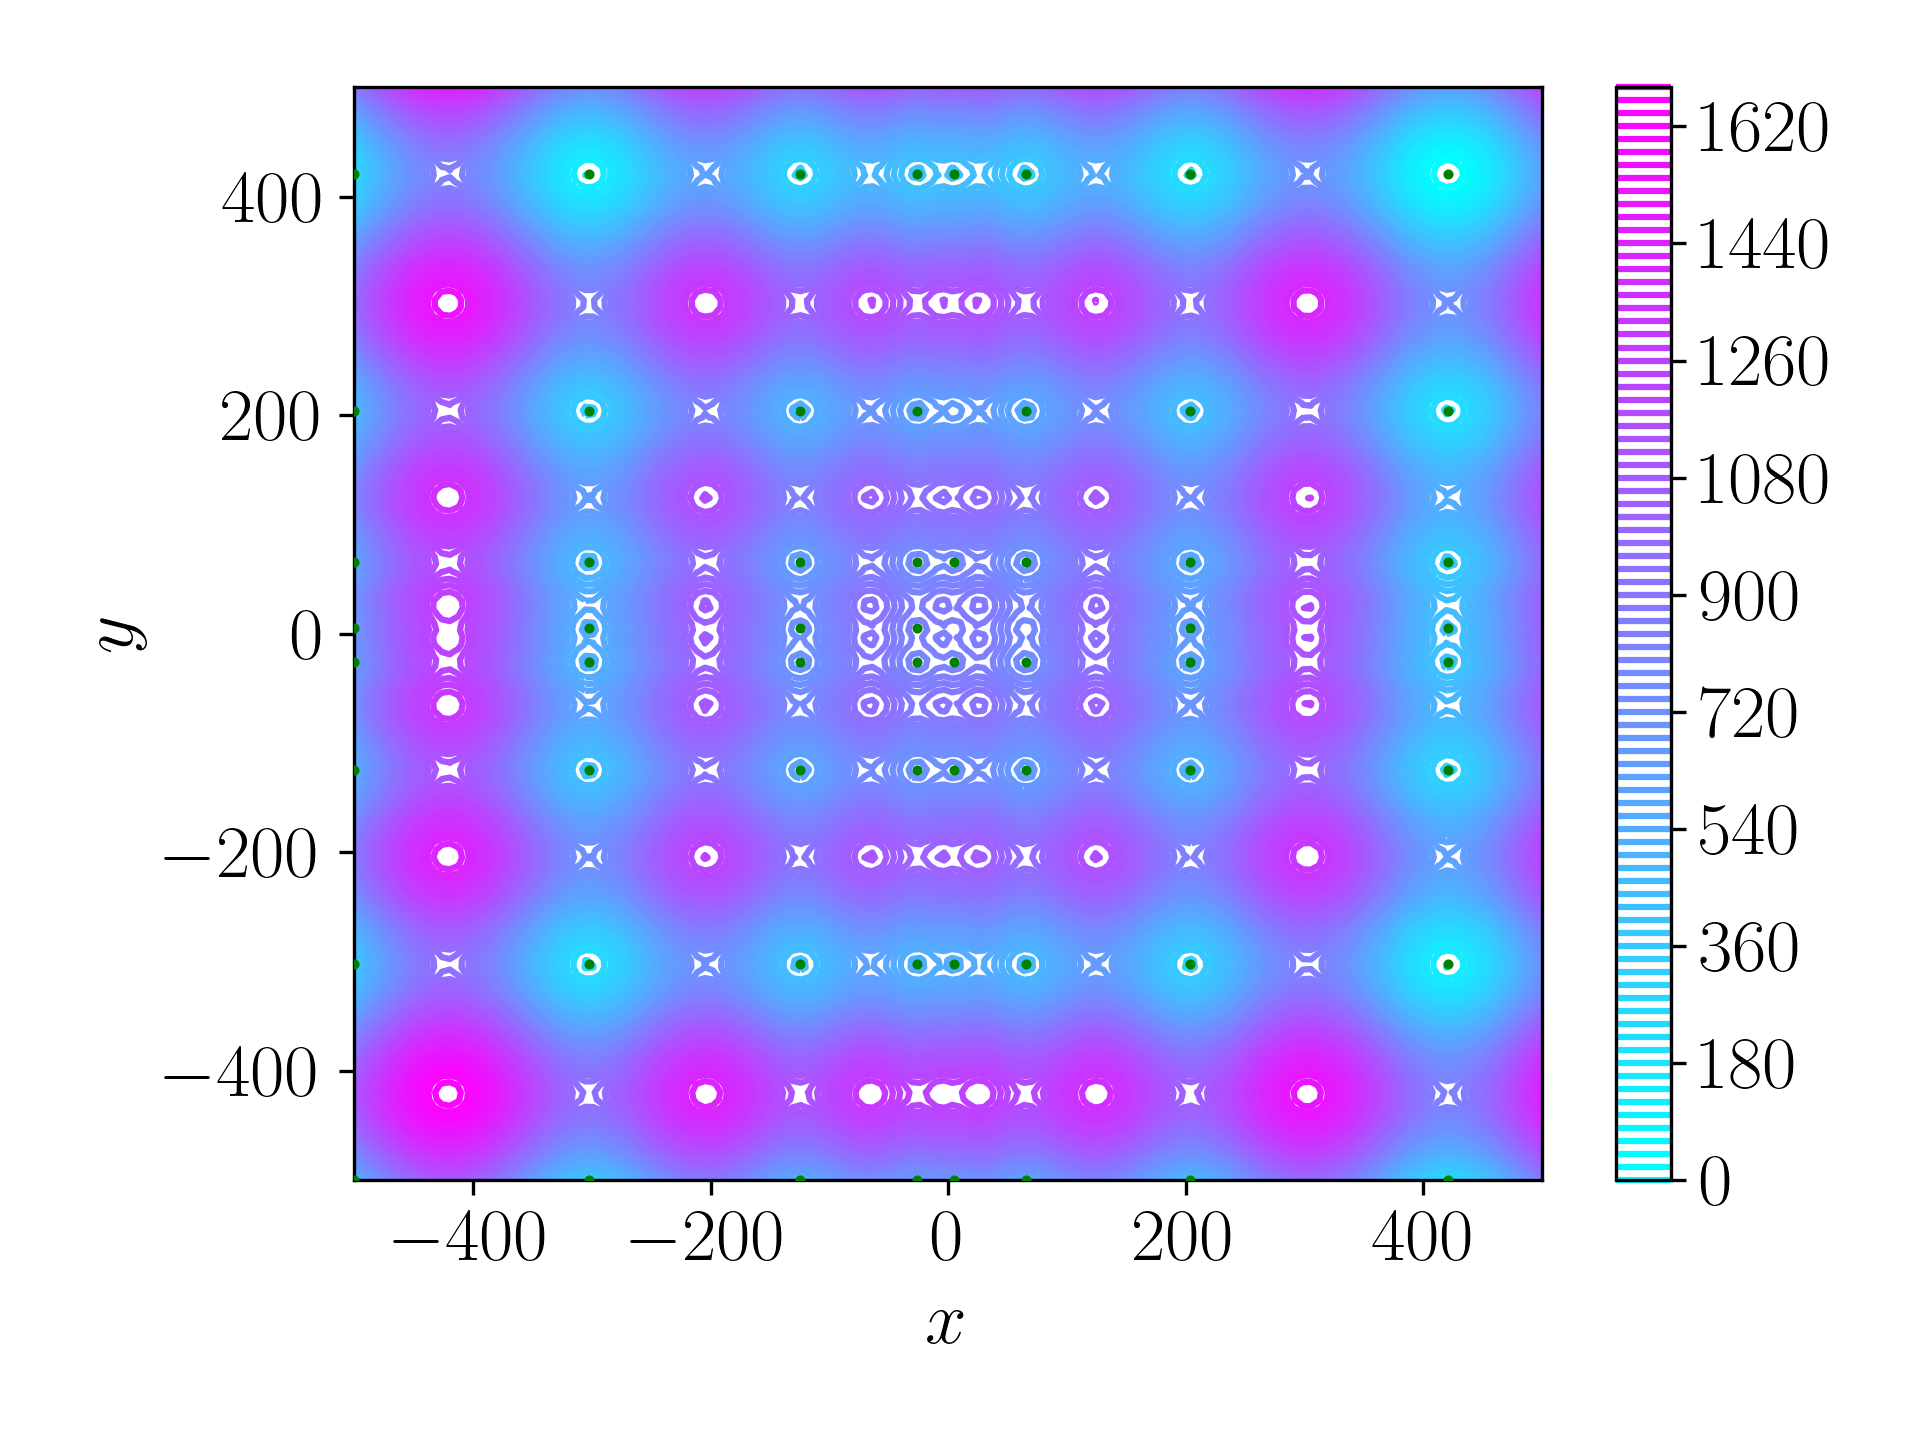

In [117]:
from IPython.display import Image
from topsearch.plotting.stationary_points import plot_stationary_points
plot_stationary_points(potential=schwefel, # function we want to plot
                       ktn=ktn, # the network of minima and transition states to overlay
                       bounds=coords.bounds, # the limits of the function plotting
                       contour_levels=100, # the number of con
                       fineness=150) # the 
Image(filename='StationaryPoints.png')

In green we see the local minima that basin-hopping has located, which for this trivial example is exhaustive. We can save this network of minima easily using

In [118]:
ktn.dump_network('.minima_only')

which writes the network to files: min.data, ts.data, min.coords, ts.coords and pairlist.txt. The format of each is a text file containing columns giving the following information, where each line in min/ts.data corresponds to the same line in min/ts.coords

- min.data:   index potential_energy
- min.coords: atomic_coordinates
- ts.data:    connected_min1 connected_min2 potential_energy
- ts.coords:  atomic_coordinates
- pairlist:   the pairs of minima we have attempted transition states between


## 2. Find transition states

Having successfully located the local minima we will locate the transition states between them. These transition states are the maxima on the minimum energy paths between minima and describe the intermediate structure of the surface between minima. In two dimensions each transition state can be seen as maximal in one direction and minimal in the orthogonal direction. With transition states as well this network of stationary points can encode the topography of the surface. 

Location of the transition states is performed by using the combination of single and double-ended transition state searches between minima. We select pairs of minima, between which we attempt to find transition states, using the 'ClosestEnumeration' algorithm. This scheme specifies that we attempt to connect all minima to their `cycles` nearest neighbours within the space. The generation of all transition states can be performed with the following method

In [119]:
explorer.get_transition_states(method='ClosestEnumeration', # the scheme for selecting pairs of minima to connect
                               cycles=8, # the number of neighbours 
                               remove_bounds_minima=True) # whether to ignore minima at bounds of allowed space

We have performed all the transition state searches between each minimum and its 8 nearest minima. To see these transition states we can again use the plotting functionality

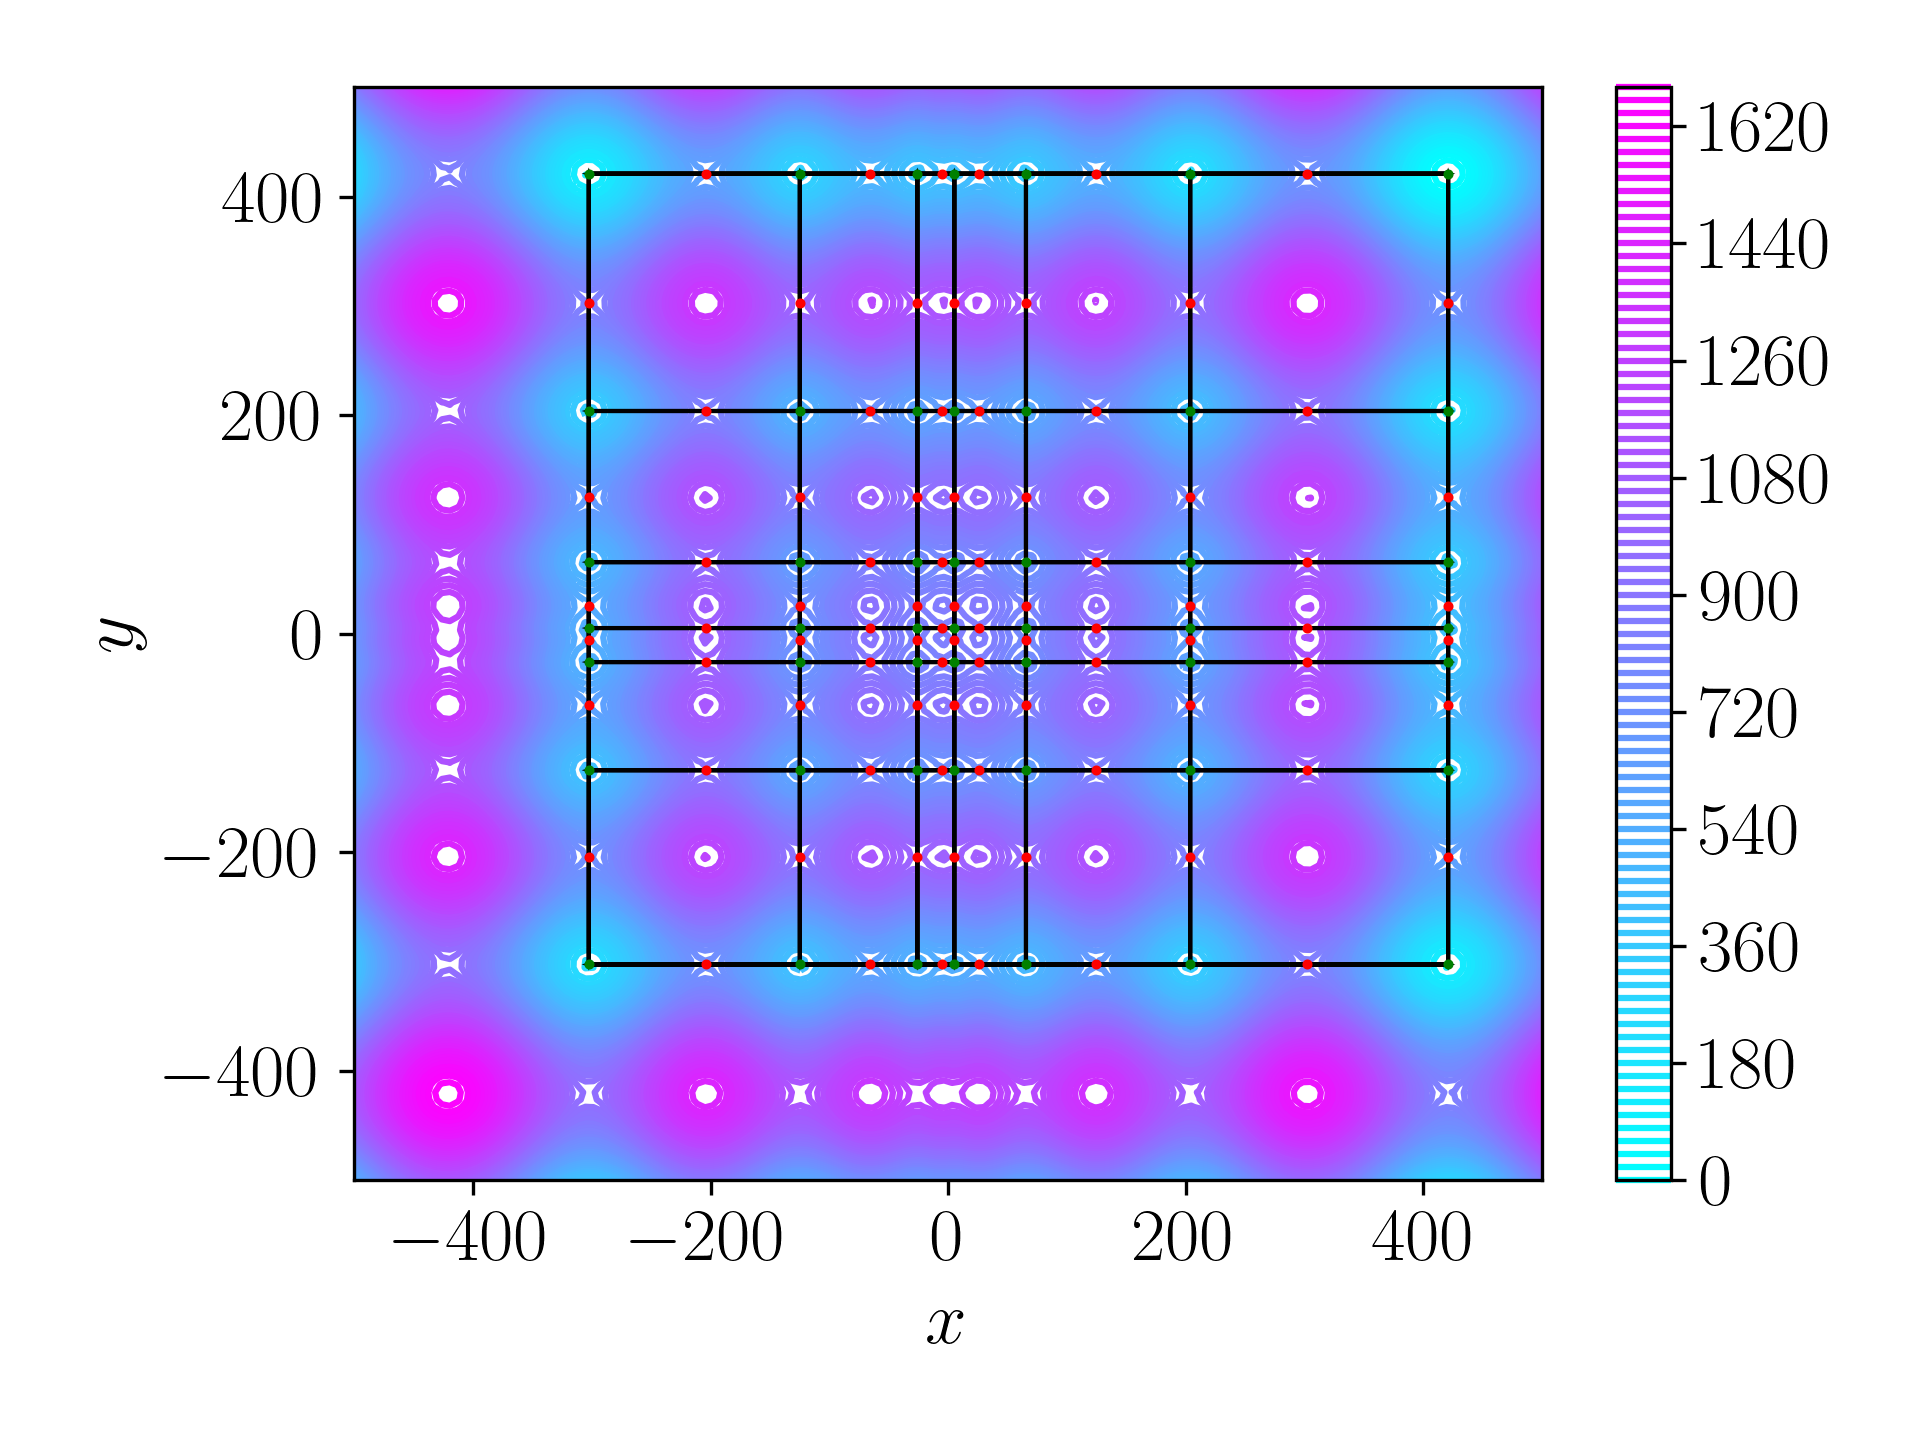

In [120]:
plot_stationary_points(potential=schwefel, # the function we are plotting
                       ktn=ktn, # network storing minima and transition states
                       bounds=coords.bounds, # the extent of plotting for the function
                       contour_levels=100, # controls the quality/smoothness of the function
                       fineness=150) # controls the quality/smoothness of the function
Image(filename='StationaryPoints.png')

We can see from the image that we have located all the transition states between the set of minima we started with. Each transition state, denoted by a red dot, is connected to two minima by minimisation along the downhill directions. In this plot the connections are shown with solid black lines.

## 3. Restarting calculations

For functions that are more expensive to evaluate, or those of higher dimensionality, it may not be possible to run these previous two steps in one go. However, it is very easy to restart calculations from an existing landscape as we will do here. We are going to take the landscape we previously stored containing only local minima. Reading in an existing database is performed using

/Users/lukedicks/topography-searcher/src/topsearch/data/kinetic_transition_network.py:154: UserWarning: loadtxt: input contained no data: "ts.data.minima_only"
  ts_data = np.loadtxt(f"{text_path}ts.data{text_string}")
/Users/lukedicks/topography-searcher/src/topsearch/data/kinetic_transition_network.py:155: UserWarning: loadtxt: input contained no data: "ts.coords.minima_only"
  ts_coords = np.loadtxt(f"{text_path}ts.coords{text_string}")
/Users/lukedicks/topography-searcher/src/topsearch/data/kinetic_transition_network.py:156: UserWarning: loadtxt: input contained no data: "pairlist.minima_only"
  self.pairlist = np.loadtxt(f"{text_path}pairlist{text_string}",


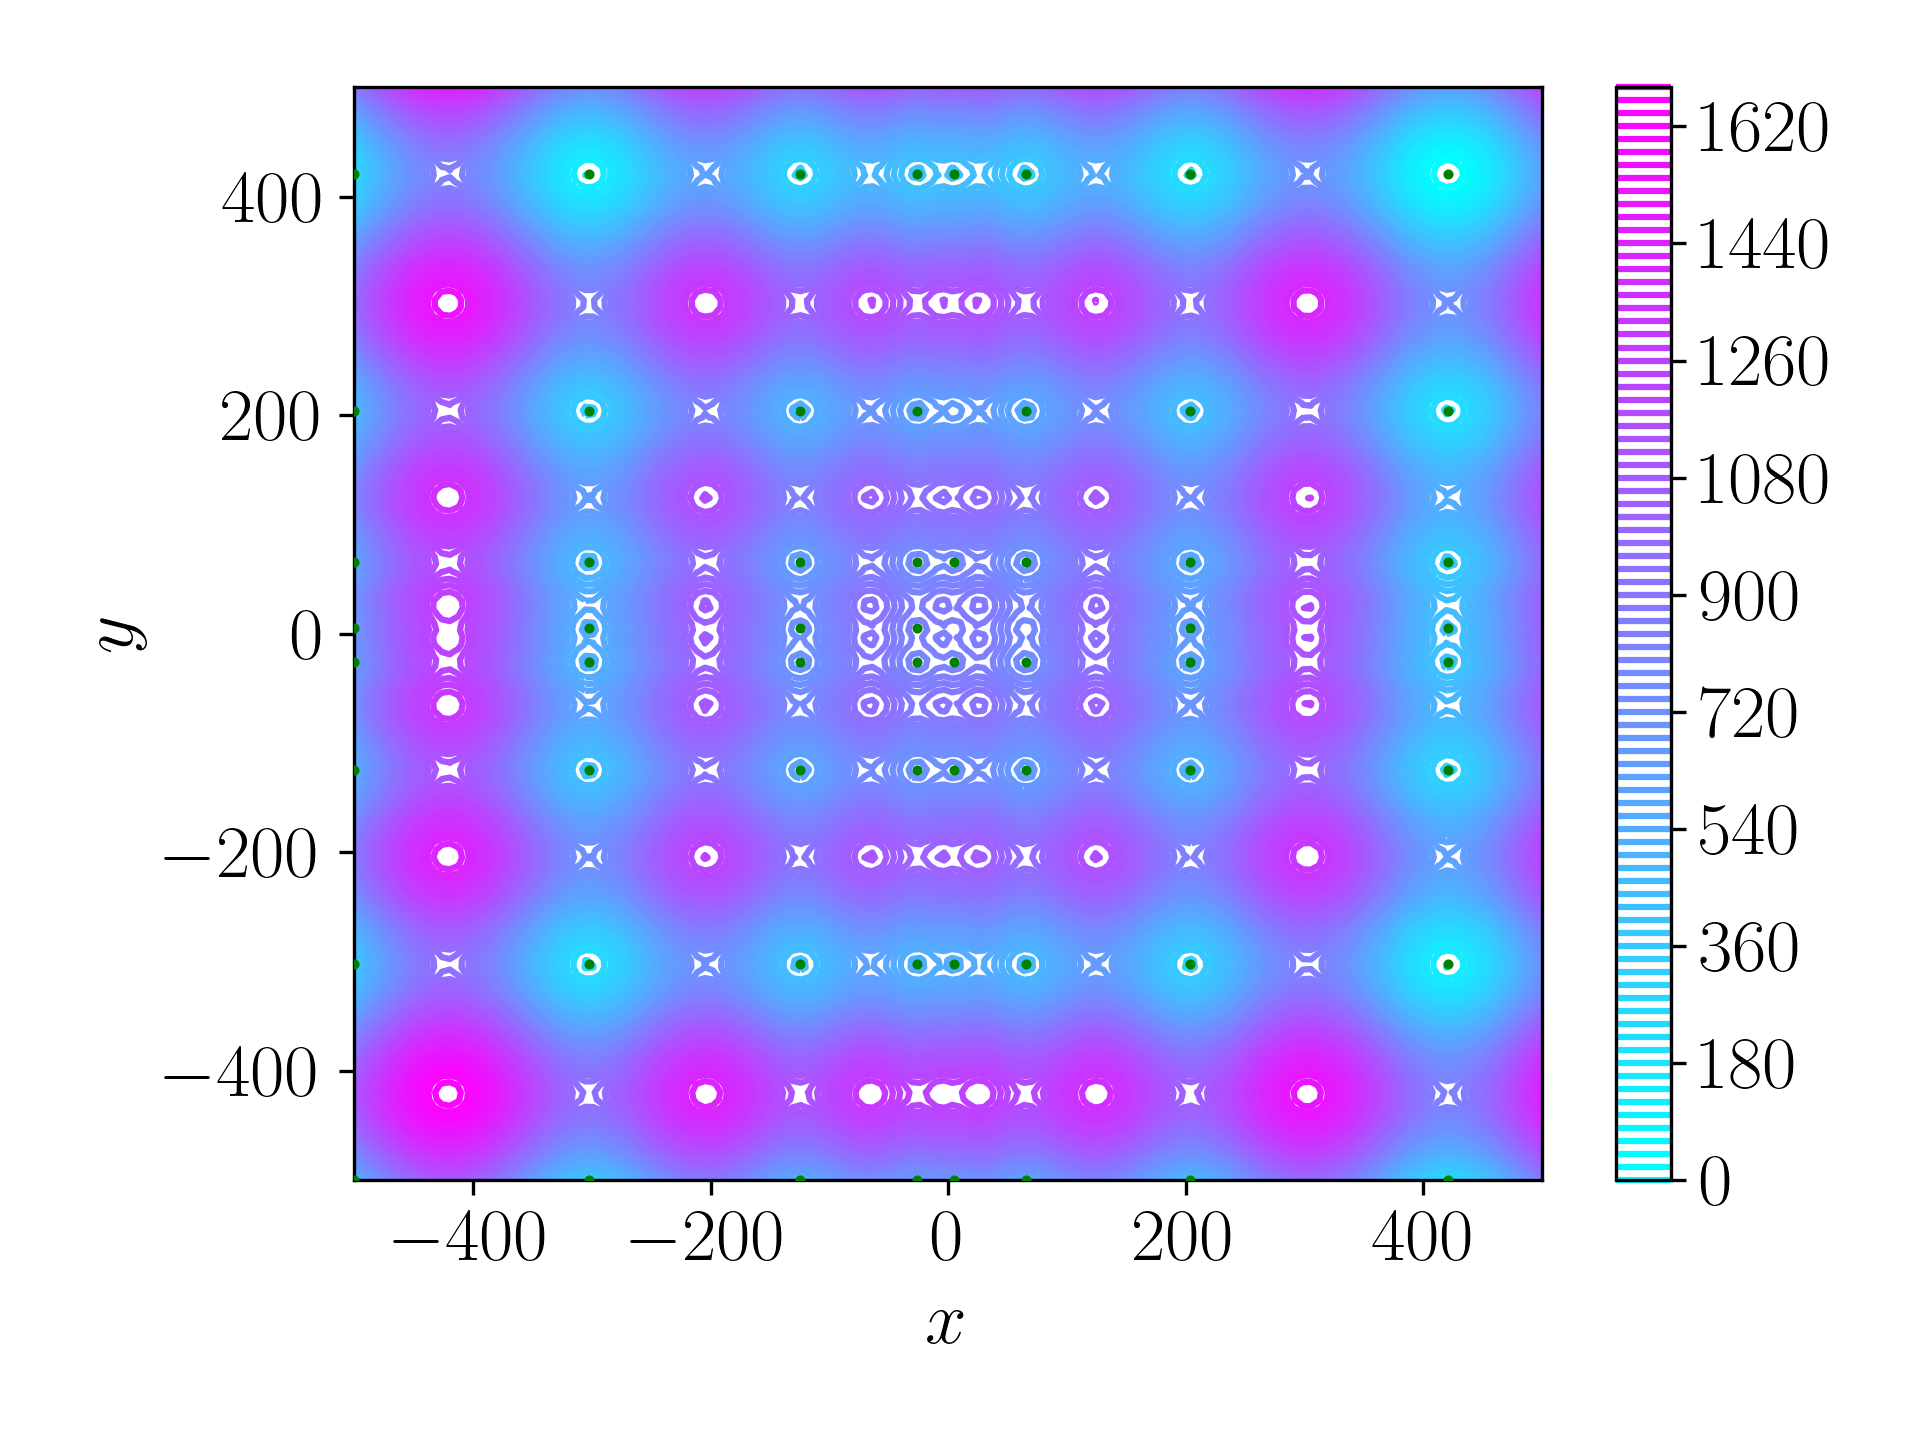

In [121]:
ktn.reset_network() # Check the network is empty
ktn.read_network(text_string='.minima_only') # Read in the network containing only minima
plot_stationary_points(potential=schwefel,
                       ktn=ktn,
                       bounds=coords.bounds,
                       contour_levels=100,
                       fineness=150)
Image(filename='StationaryPoints.png')

We can easily validate that we now have a network containing only the minima (shown in green) again. It is possible to read in a network with any number of minima and transition states and then find more minima and transition states. Since this network already contains all the minima we will only do transition state searches to regenerate the landscape we have previously containing all transition states.

In [122]:
from timeit import default_timer
serial_start_time = default_timer()
explorer.get_transition_states(method='ClosestEnumeration',
                               cycles=8,
                               remove_bounds_minima=True)
serial_end_time = default_timer()

We can again visualise the network to show that we have successfully regenerated the complete landscape. You will have noticed that we also timed the transition state searches as we will compare them to the same method called using multiprocessing in the next section.

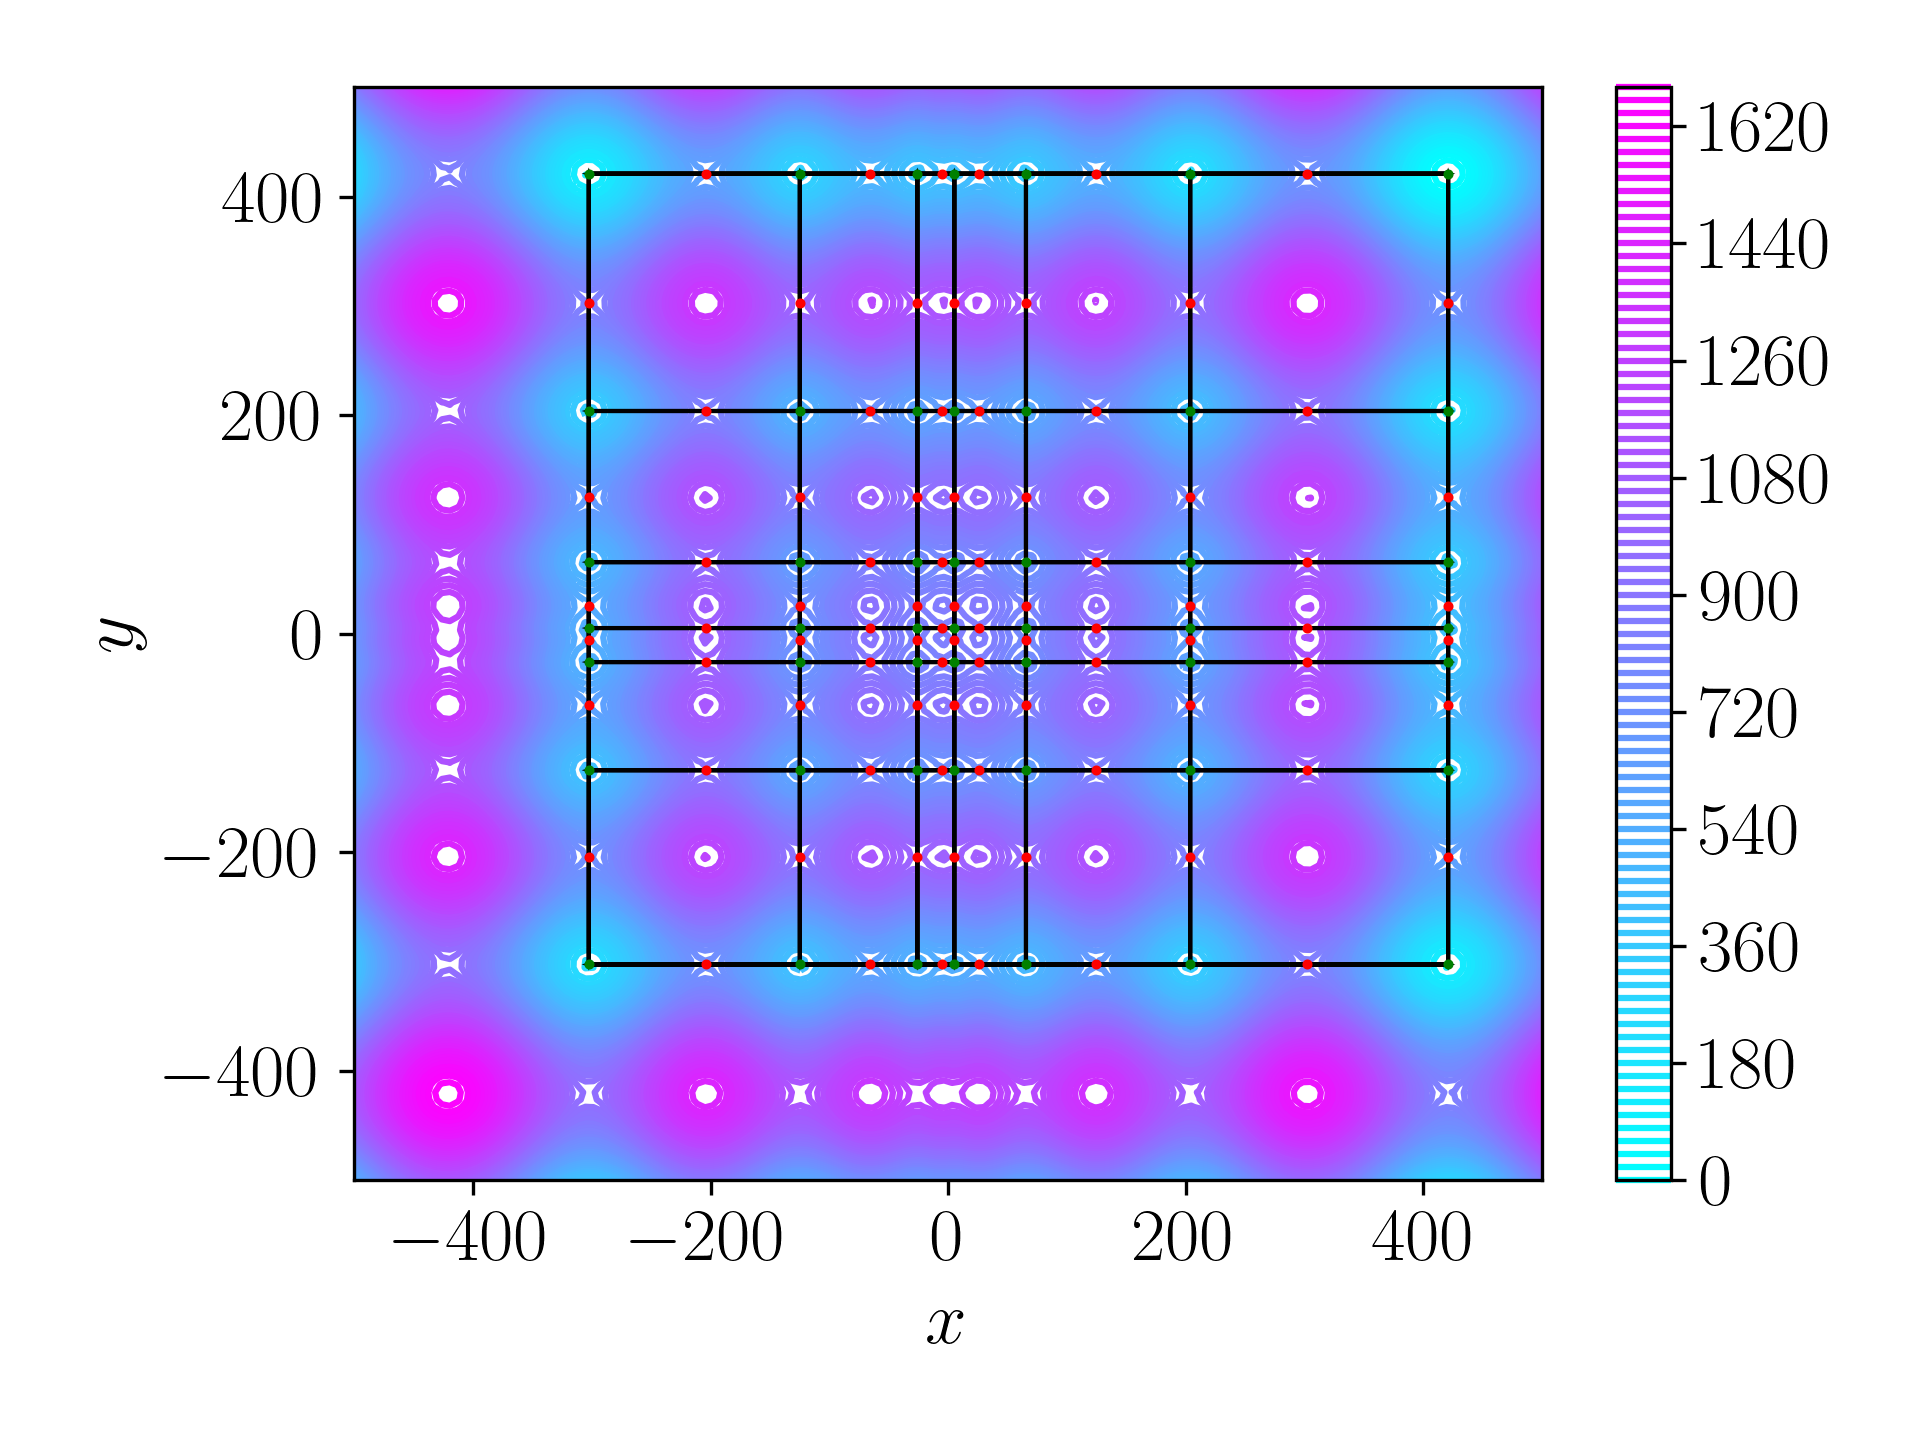

In [123]:
plot_stationary_points(potential=schwefel,
                       ktn=ktn,
                       bounds=coords.bounds,
                       contour_levels=100,
                       fineness=150)
Image(filename='StationaryPoints.png')

Here, we provide two further visualisations. Above two dimensions we cannot directly observe the surface, which means we require alternative visualisations that still reveal the structure of the surface. Two examples are disconnectivity graphs and network visualisation. First we produce the disconnectivity graph for this kinetic transition network

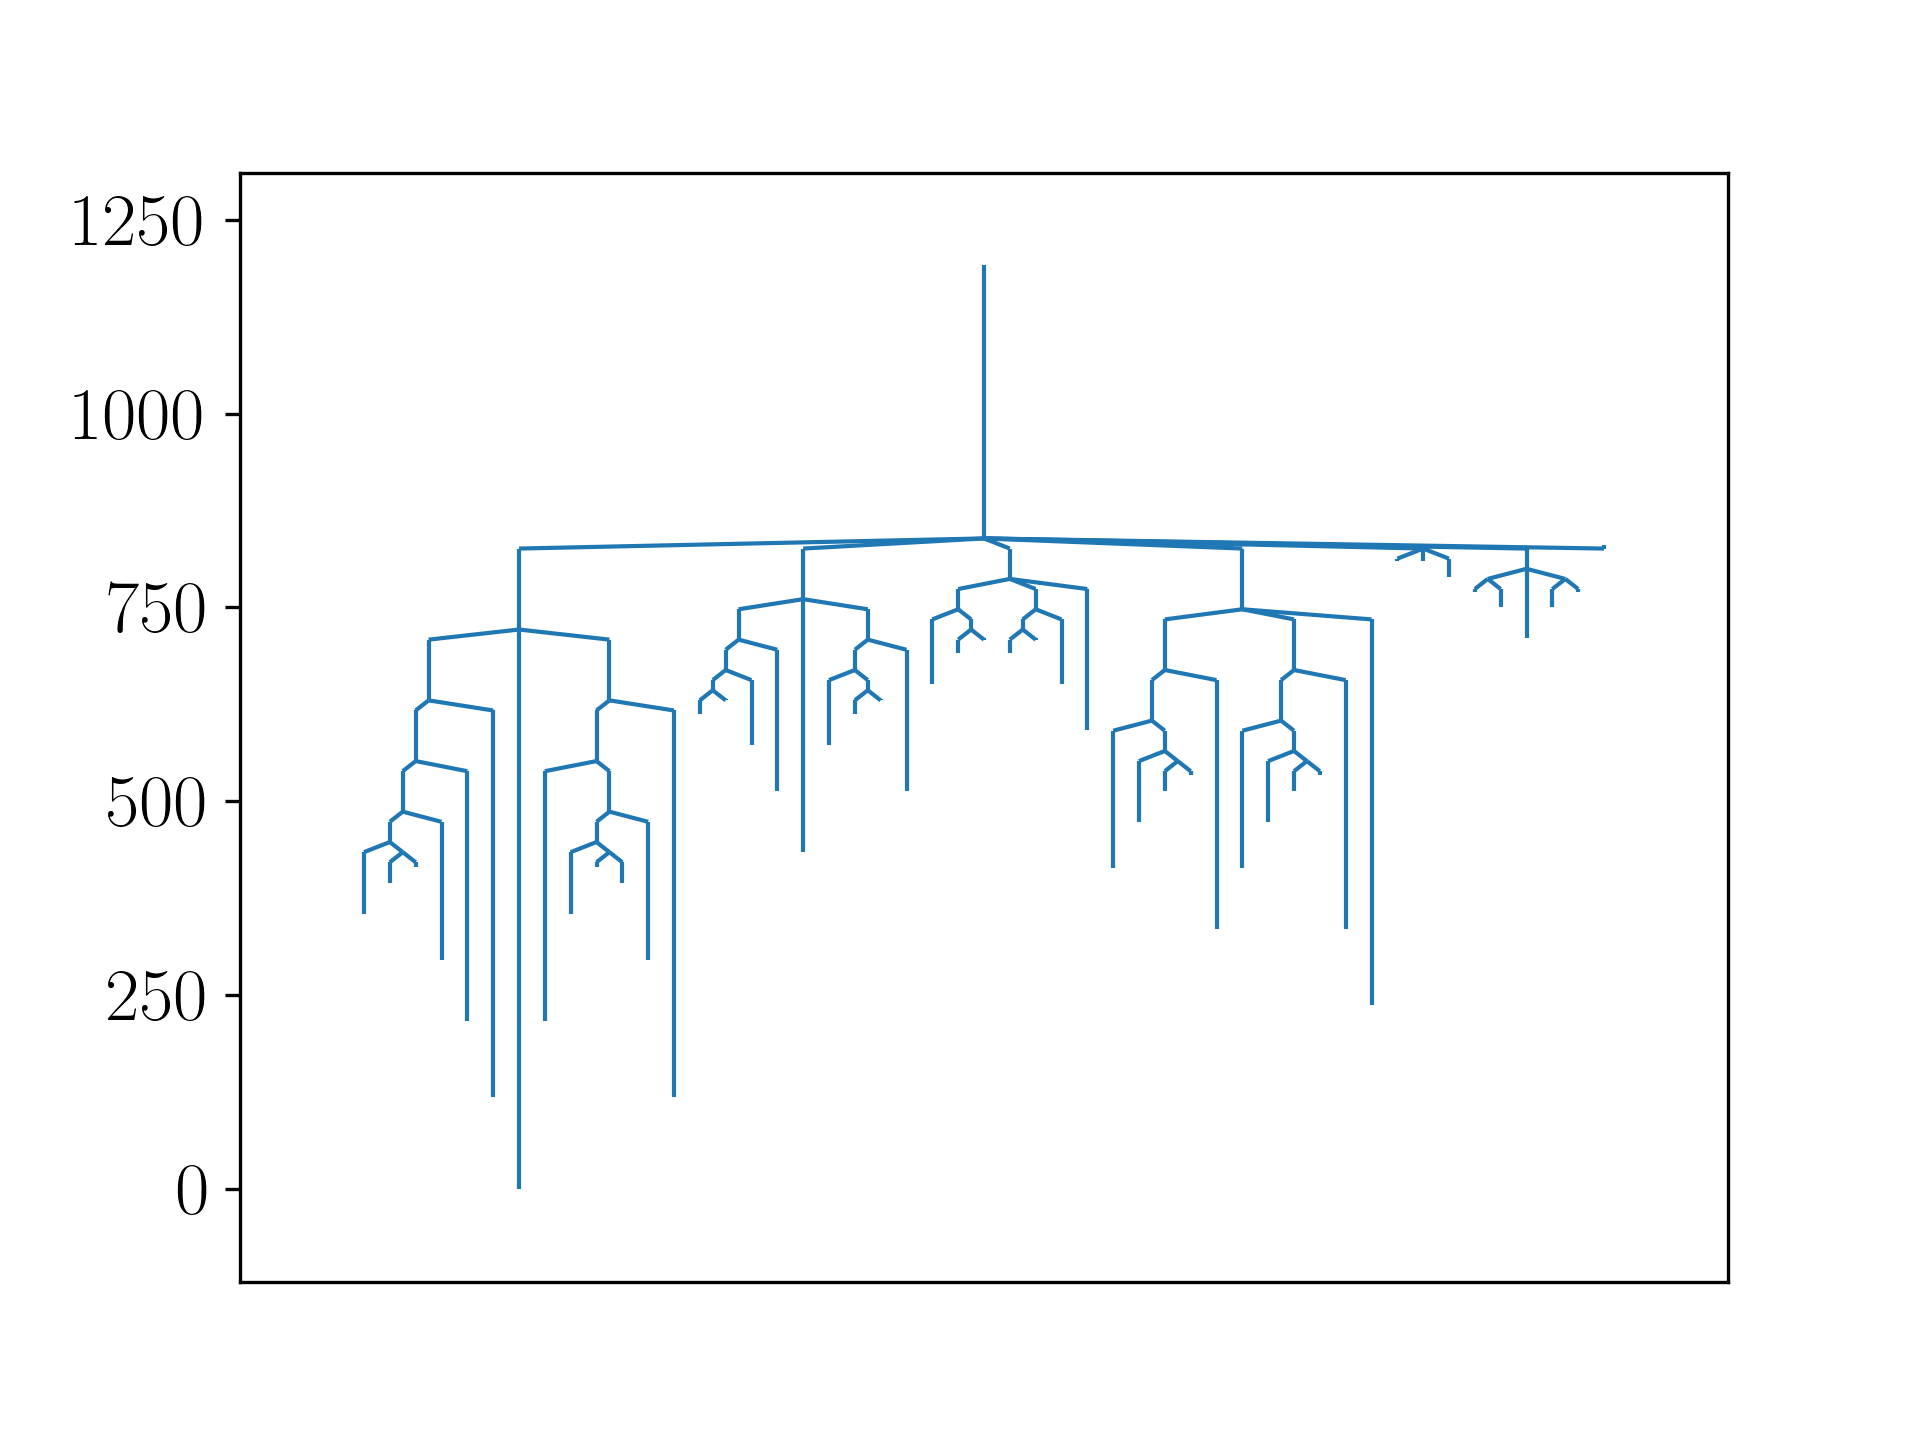

In [124]:
from topsearch.plotting.disconnectivity import plot_disconnectivity_graph
plot_disconnectivity_graph(ktn=ktn,
                           levels=100)
Image(filename='DisconnectivityGraph.png')

Disconnectivity graphs (https://doi.org/10.1038/29487) can be used for surfaces of any dimensionality. They display the minima and the barriers (via transition states) needed to move between them, which are relevant quantities for understanding the topology of abstract surfaces. Each vertical line is a local minimum which ends at its corresponding function value. The lines merge at the function value at which the two minima become intercovertible, which is the value of the maximum transition state on a path between them. Here we see the organisation of this surface into five distinct regions, each of which require the same function value to be reached to move between them.

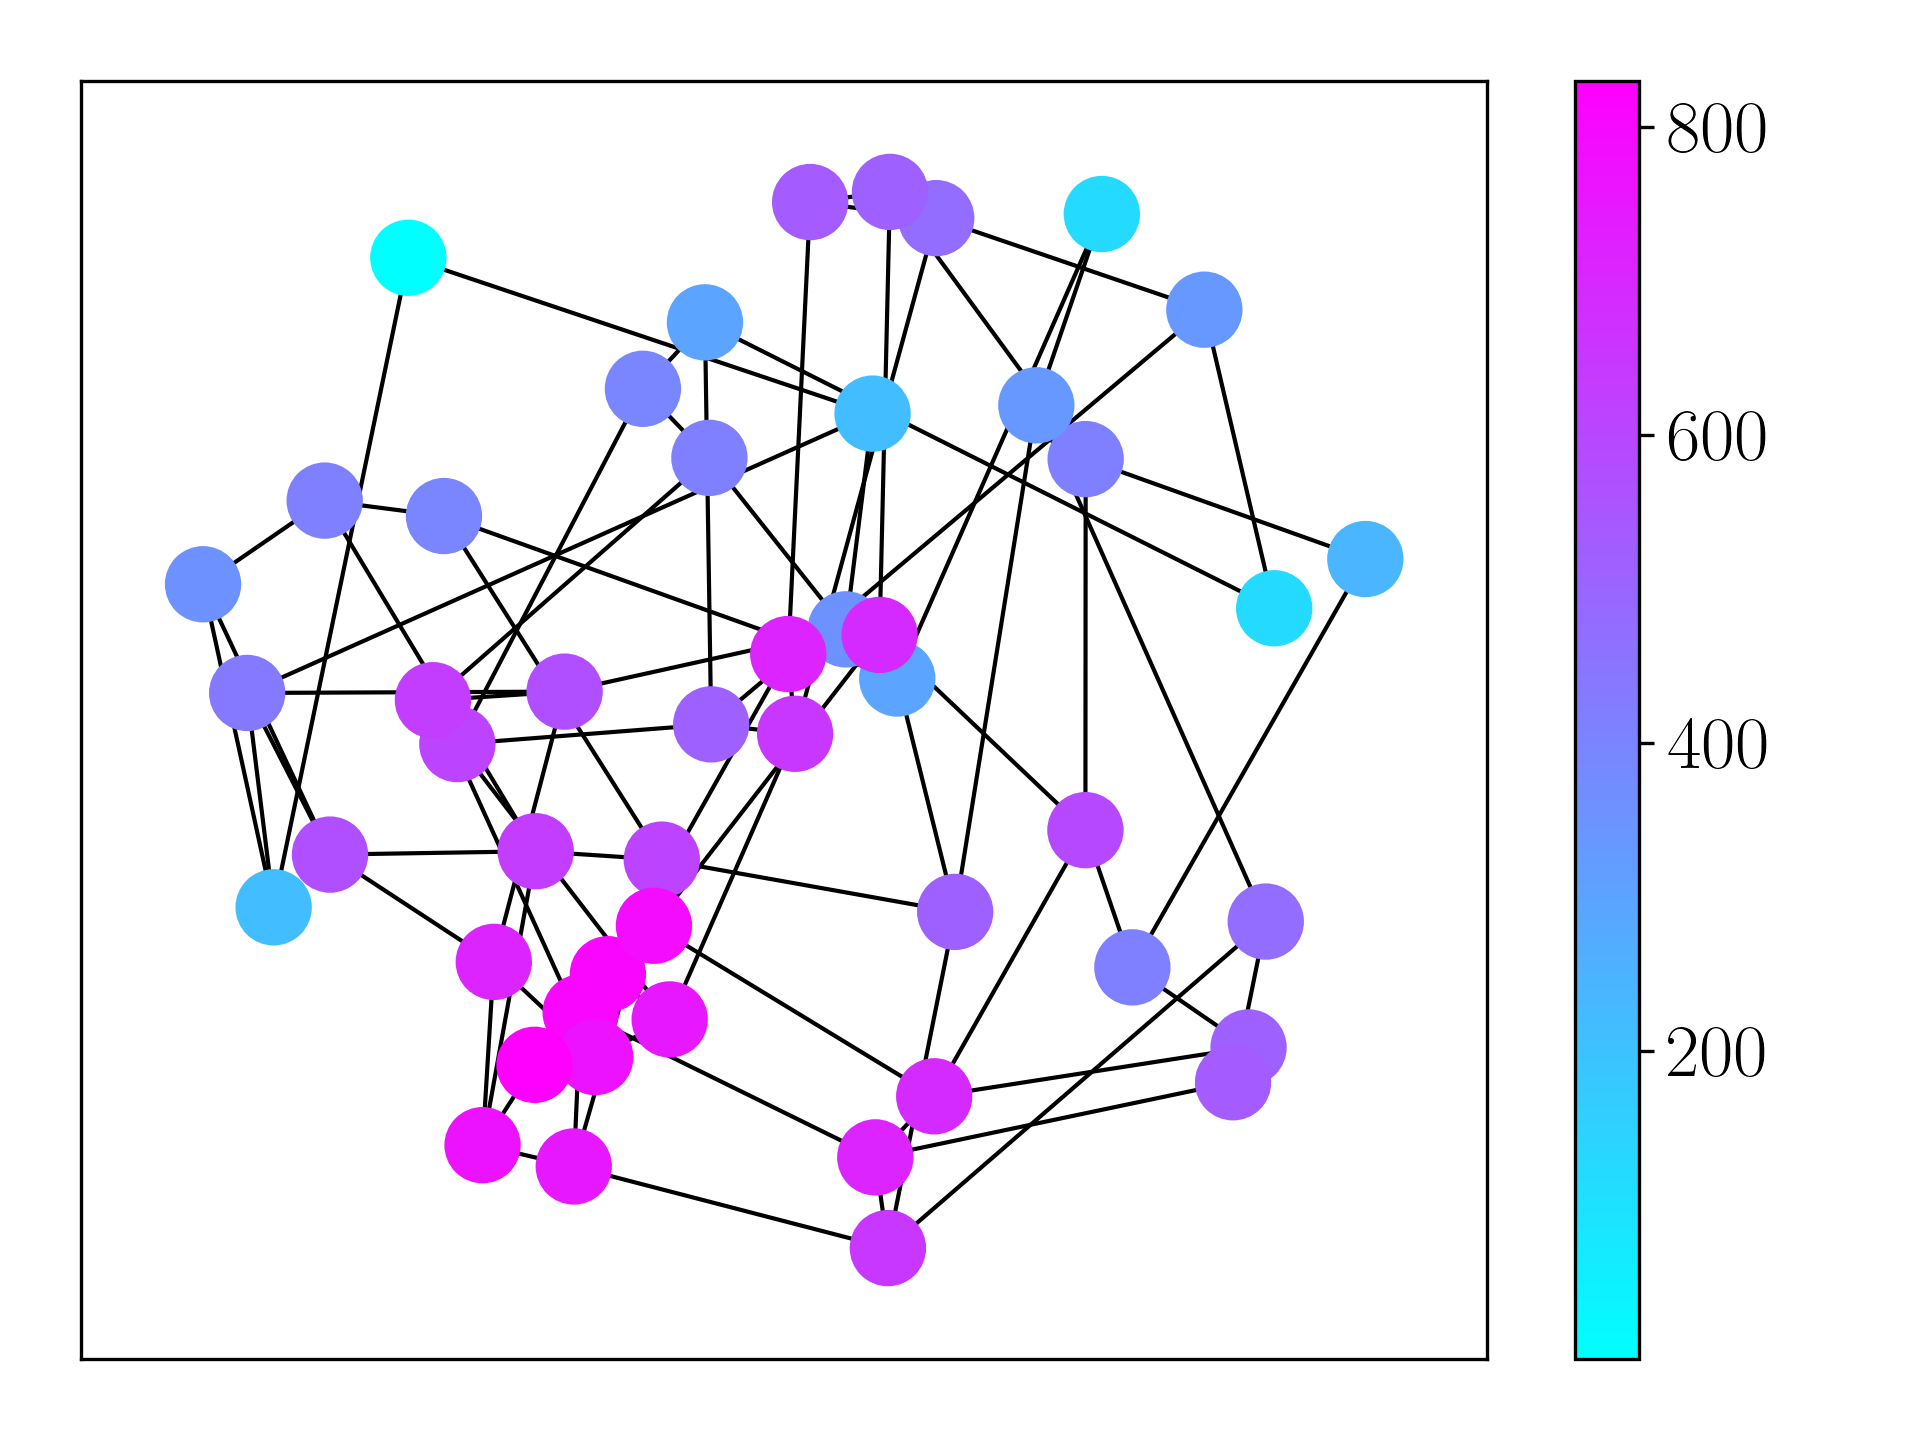

In [125]:
from topsearch.plotting.network import plot_network
plot_network(ktn)
Image(filename='Network.png')

The network plot illustrates the graph in a representation that respects the barriers between minima to enforce edges to be shorter if the transition state barrier is lower. Therefore, the graph gives a visual illustration of surface topography in two dimensions, highlighting groups of nodes that are close together as those within a smooth part of the surface.

## 4. Restart with multiprocessing

The transition state searches are embarassingly parallel, we repeat many transition state searches for different pairs of minima, each of which requires no information from the others. Therefore, we can use multiprocessing to further accelerate the exploration of the surface by running each separate transition state search on a different process. After an initial generation of the set of minima that should be connected we spread the calculations across n_processes. Usually we would specify this option when initialising the NetworkSampling object, but here we simply update these values

In [126]:
explorer.multiprocessing = True
explorer.n_processes = 6

Now any landscape exploration will be performed in parallel over n_processes different processes. We read in the network in the same state as for the previous serial computation and perform the same set of calculations, this time with multiple processes.

In [127]:
from timeit import default_timer
ktn.reset_network()
ktn.read_network(text_string='.minima_only')

In [128]:
parallel_start_time = default_timer()
explorer.get_transition_states(method='ClosestEnumeration',
                               cycles=8,
                               remove_bounds_minima=True)
parallel_end_time = default_timer()
print("Serial computation time = ", serial_end_time - serial_start_time)
print("Parallel computation time = ", parallel_end_time - parallel_start_time)

Serial computation time =  17.87926616705954
Parallel computation time =  17.659563416964374


Printing the timings for both of these methods we can show that the multiprocessing provides a large reduction in computational time when multiple cores are available.